In [2]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import sklearn; 
import seaborn as sns; import re; import nltk; from nltk.tokenize import word_tokenize; 
from nltk.stem import PorterStemmer; nltk.download("stopwords"); from nltk.corpus import stopwords;
nltk.download('punkt'); from sklearn.model_selection import train_test_split; 
from sklearn.naive_bayes import MultinomialNB; from sklearn.metrics import accuracy_score;
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /Users/jamie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jamie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Load the data**

In [3]:
data = pd.read_csv('Wine_data.csv',index_col=0)

In [4]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


**Inspect the data and establish target variable**

I will be using the _variety_ variable as my target, _y_, variable. Therefore, must inspect the number of unique categories and the respective counts for each. 

In [5]:
len(data['variety'].unique())

632

632 is far too many output classes therefore will filter for only those with a significant number of reviews. 

In [6]:
categories = data['variety'].value_counts()[:20] # Shows the top 20 categories wrt number of instances
categories

Chardonnay                       14482
Pinot Noir                       14291
Cabernet Sauvignon               12800
Red Blend                        10062
Bordeaux-style Red Blend          7347
Sauvignon Blanc                   6320
Syrah                             5825
Riesling                          5524
Merlot                            5070
Zinfandel                         3799
Sangiovese                        3345
Malbec                            3208
White Blend                       2824
Rosé                              2817
Tempranillo                       2556
Nebbiolo                          2241
Portuguese Red                    2216
Sparkling Blend                   2004
Shiraz                            1970
Corvina, Rondinella, Molinara     1682
Name: variety, dtype: int64

I will filter to use only those with 5,000+ instances per class. 

This dataset will be imbalanced so I will trim undersample those classes with >5,000 so I have 5,000 instances for each class.

In [7]:
target_var_counts = categories[categories > 5000]
target_var_counts

Chardonnay                  14482
Pinot Noir                  14291
Cabernet Sauvignon          12800
Red Blend                   10062
Bordeaux-style Red Blend     7347
Sauvignon Blanc              6320
Syrah                        5825
Riesling                     5524
Merlot                       5070
Name: variety, dtype: int64

Bar plot of the class distribution.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

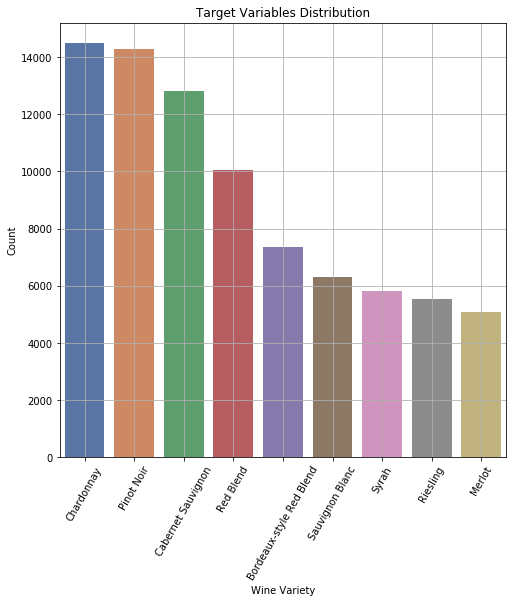

In [8]:
plt.figure(figsize=(8,8))
sns.barplot(target_var_counts.index,target_var_counts.values,palette='deep')
plt.title('Target Variables Distribution')
plt.ylabel('Count')
plt.grid('on')
plt.xlabel('Wine Variety')
plt.xticks(rotation=60)

In [9]:
target_variables = list(target_var_counts.index)
target_variables

['Chardonnay',
 'Pinot Noir',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Sauvignon Blanc',
 'Syrah',
 'Riesling',
 'Merlot']

Filter the whole dataset such that it only includes those of our target class

In [10]:
updated_data = data[data.variety.isin(target_variables)]
print(
    'Old dataset shape: ', data.shape, ' New dataset shape: ', updated_data.shape
)

Old dataset shape:  (150930, 10)  New dataset shape:  (81721, 10)


This has roughly halved the dataset. 

In [11]:
updated_data.head()

updated_data.index = range(len(updated_data)) # Reset the index 

updated_data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
2,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
3,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
4,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


My X variable is going to be the description for each wine. 

In [12]:
# Check to see if there are any null entries in the independent variables 

len(data['description'][data['description'].isna()])

0

In [13]:
# Check average length of description 

counts = []

for i in updated_data['description']:
    counts.append(len(i))
    
np.array(counts).mean()

243.44675175291542

On average each review is 243 words long. This may not be enough to establish differences between language patterns used to describe each different wine, especially with the removal of stop words.

**Balancing the dataset**

Since the new dataset is still fairly imbalanced I will balance it. To do this I will essentially undersample those classes with >5000 instances to the point where I have exactly 5000 for each instance. 

In [14]:
balanced_data = pd.DataFrame(columns=updated_data.columns)

for i in target_variables:
    class_df = updated_data[updated_data['variety']==i].iloc[:5000,] # Continually appends the first 5,000 of each category to an empty dataframe
    balanced_data = balanced_data.append(class_df,ignore_index=True)
   

**Establish X and y** 

X will eventually be a _bag of words_ and y will simply be a column vector indicating response variable - wine variety. 

In [15]:
corpus = [] # This will be a collection of the descriptions for each instance 

for i in range(len(balanced_data)):
    corpus.append(balanced_data['description'].iloc[i,])

I will need to do some basic **Natural Language Processing** on the descriptions before they can be used in the model.

Some of this is simple such as changing everything to lower case, removing punctuation and stripping whitespace. However, some of this will be more complex such as removing **stop words** and **stemming** words. 

Stop words are words commonly used however add little meaning to the context - words such as conjuctions. 

Stemming involves things such as changing words from the plural form to the singular or changing words into a 'base' form. An example would be stemming the words 'Connections', 'Connecting', Connectors' all into the same word of 'Connect'. 

In [16]:
# Formates to lower case, removes punctuation and white space 

for i in range(len(corpus )):
    corpus[i] = corpus[i].lower()
    corpus[i] = re.sub(r'\W',' ',corpus[i])
    corpus[i] = re.sub(r'\s+',' ',corpus[i])

# Stemming and stop words are removed from the documents 

filtered_corpus = []
ps = PorterStemmer()
sw = stopwords.words('english')

for doc in corpus:
    tokens = word_tokenize(doc)
    tmp = ''
    for w in tokens:
        if w not in sw:
            tmp += ps.stem(w) + ' '
    filtered_corpus.append(tmp)

Unfortunately the processing done above may run slowly on very large datasets. 

In [17]:
words = [] # This will store the entire collection of words which can be used later 
for doc in filtered_corpus:
    tokens = word_tokenize(doc)
    for token in tokens:
        if token not in words:
            words.append(token)

In [18]:
print(
    'Total number of words in descriptions: ', len(words)
)

Total number of words in descriptions:  13794


In [19]:
document_vectors = []

for doc in filtered_corpus:
    doc_tokens = word_tokenize(doc)
    doc_vec = []
    for token in words:
        if token in doc_tokens:
            doc_vec.append(1)
        else:
            doc_vec.append(0)
    document_vectors.append(doc_vec)

 # this is the finished bag of words, the X variable

X = np.array(document_vectors)

In [22]:
# Here I turn the vectors into a dataframe to visualise how the bag of words model appears.

X_df = pd.DataFrame(document_vectors,columns=words)

**Bag of Words**

In [ ]:
X_df.head()

In [23]:
# Creates a final column in the dataframe representing the response variables

X_df['Class'] = balanced_data['variety'] 

In [24]:
# Splits the dataframe into a training and validation set
# The 'stratify' parameter assures that there are an even distribution of the Class variables in each set.

df_train, df_val = train_test_split(X_df,test_size=0.20,stratify=X_df['Class'])

This is where I load in my **Multinomial Naive Bayes** model and then fit it to my training dataframe. 

Following this I can then use the fitted model to make predictions on the validation dataset which can then compared to the y values in the test set to assess model accuracy. 

In [25]:
clf = MultinomialNB()
clf.fit(X=df_train.drop(['Class'],axis=1),y=df_train['Class'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
y_pred = list(clf.predict(df_val.drop(['Class'],axis=1))) #Predict topics 
y_true = list(df_val['Class'])

print(
    'Accuracy score of model: ', accuracy_score(y_true,y_pred)*100, '%'
)

Accuracy score of model:  76.32222222222222 %


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text yticklabel objects>)

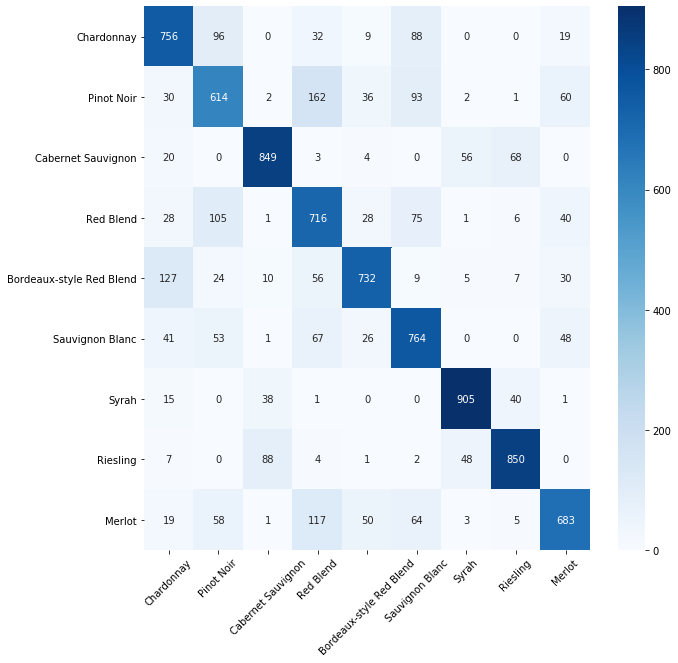

In [27]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(y_true,y_pred),cmap='Blues',annot=True,fmt='')
ax.set_xticklabels(target_variables)
ax.set_yticklabels(target_variables)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

These results are pretty impressive. A 75% accuracy rate among 7 classes based on (on average) 240 word descriptions with some basic natural language processing. 

One potential (bad) reason for why this result was obtained is that many of the reviews may directly mention the target class in the description.

I will therefore add the words for the target variables into the words removed in my NLP steps and observe whether the accuracy becomes lower. The steps following are exactly the same as previously however 

In [28]:
new_filtered_corpus = []

new_sw = stopwords.words('english')

for word in target_variables: # This will append the target variable words to the stop words list
    new_sw.append(word) # Therefore this will remove the target variables from the descriptions

for doc in corpus:
    tokens = word_tokenize(doc)
    tmp = ''
    for w in tokens:
        if w not in new_sw:
            tmp += ps.stem(w) + ' '
    new_filtered_corpus.append(tmp)

In [29]:
new_words = []
for doc in new_filtered_corpus:
    tokens = word_tokenize(doc)
    for token in tokens:
        if token not in new_words:
            new_words.append(token) 
            
print(
    'Total number of words in updated version: ', len(new_words)
)

Total number of words in updated version:  13794


In [30]:
new_document_vectors = []

for doc in new_filtered_corpus:
    doc_tokens = word_tokenize(doc)
    doc_vec = []
    for token in new_words:
        if token in doc_tokens:
            doc_vec.append(1)
        else:
            doc_vec.append(0)
    new_document_vectors.append(doc_vec)

 # this is the finished bag of words, the X variable

new_X = np.array(document_vectors)

In [32]:
new_X_df = pd.DataFrame(new_document_vectors,columns=new_words)

In [33]:
new_X_df['Class'] = balanced_data['variety']

In [34]:
new_df_train, new_df_val = train_test_split(new_X_df,test_size=0.20,stratify=new_X_df['Class'])

In [35]:
clf = MultinomialNB()
clf.fit(X=new_df_train.drop(['Class'],axis=1),y=new_df_train['Class'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
new_y_pred = list(clf.predict(new_df_val.drop(['Class'],axis=1))) #Predict topics 
new_y_true = list(new_df_val['Class'])

print(
    'Accuracy score of updated model: ', accuracy_score(new_y_true, new_y_pred)*100, '%'
)

Accuracy score of updated model:  75.84444444444445 %


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text yticklabel objects>)

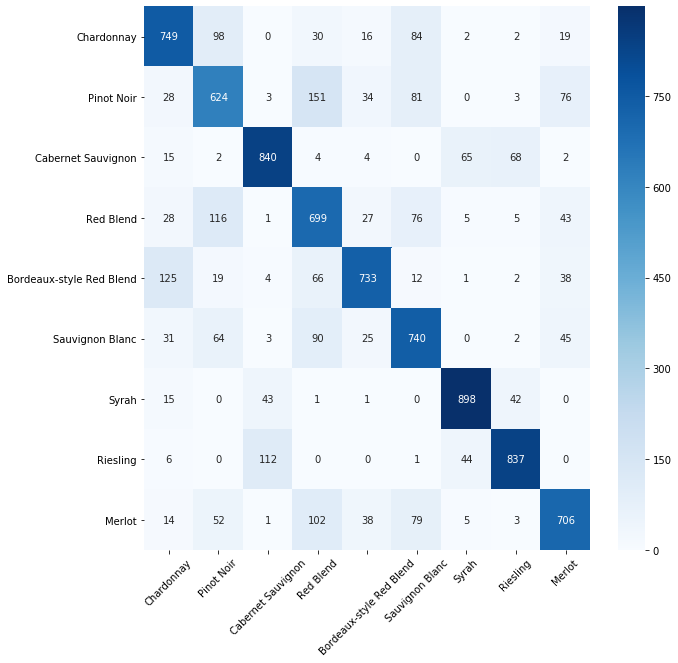

In [37]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(new_y_true, new_y_pred),cmap='Blues',annot=True,fmt='')
ax.set_xticklabels(target_variables)
ax.set_yticklabels(target_variables)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

Altering the stop words to include the target variables fortunately had a small effect upon the model's accuracy. I initially thought there could have been almost a form of 'look-ahead' bias where the descriptions may have explicitly been mentioning the target variable however, that doesn't seem to be the case. 

**Benchmarking and Reviewing Performance**

It is good practice to try and benchmark model's against some baseline performance in order to see whether the work put in is resulting in improved performance. For this task, I decided on the simplest benchmark possible for the accuracy which would be the probability of choosing correctly based on uniform (equiprobable) guesses. 

I made this decision due to the fact that I have a balanced dataset and there were no other obvious measures. Since I have 9 target variables, I could say that there is a ~11% probability of guessing correctly through a random choice. I will therefore use this probability of guessing correctly to be the long-run accuracy of randomly guessing. 

The difference between my performance and randomly guessing is ~62% which is a vast improvement. While the model may not be the best method for classifying items based on text description the model has been a success. 